<center> <h1> <span style="color:black"> Allianz Pricing Business Case  </h1> </center>
<center> <h2> <span style="color:red"> From data preparation to risk modeling </h1> </center>

<center> <h2> <span style="color:red"> Part II: modelling claim counts and amounts </h1> </center>

### 0. Authors and set-up
This case was developed by Ana Pais and Charl Marais (Allianz Benelux), in the framework of the APC module on insurance analytics, UvA, 2023-2024.

⚠️ **Initial considerations**

This script assumes that you have access to the **Google Colab** platform or that you followed the steps mentioned on **initial_setup.pdf** to work locally on your laptops (if you do have the needed permissions from your employer).
If none of the options is verified, you will not be able to proceed with the scripts provided, investigate the given data neither perform your own analysis.



📝 **Tasks**

* Each task is numbered
* Per each task, read the respective description of the task and execute the instuctions. For the majority of the tasks a cell with code is available that needs to be completed or run
* The spaces to be completed are marked with a blank space _______________
* If you do feel the need to create more cells you can click on the cell you are currently and press **B**. A new cell will be created under the active one. See for instance https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html
* Along the tasks you can find the following emojis:
    * 📢: identifies some helpful hints refering to functions that can be used or code
    * 💬: identifies discussion points. Feel free to share your opinion!

Feel free to reach out to us in case of questions!

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1. Pre-processing steps

The foundation of the technical premium assessment is to choose a fair value for the customer to pay based on their risk. To do this, the risk of the customer seeking insurance, must be estimated. The underlying assumption is that certain risk variables (or: features, covariates) are useful in explaining differences in the risk.


How to create reasonable sub-groups (or: levels, bins) when working with categorical (or: factor), continuous or spatial variables is not an easy task. Some essential considerations to keep in mind is to find as much homogeneity as possible within a level or sub-group and to make sure every sub-group has a sufficient volume of observations (or: exposure to risk). This binning task can be done by relying on expert opinion or by resorting to some data-driven strategies to specify the sub-groups of a risk variable. The latter is the topic of the Henckaerts et al. (2018) paper in Scandinavian Actuarial Journal, see [link to publisher](https://www.tandfonline.com/doi/abs/10.1080/03461238.2018.1429300) or [paper on SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3052174).



#### 1.1. Risk factors pre-processing

📝 Complete the path to load the merged policy-claim database, cfr. Part I of the Allianz Pricing Case 23-24

📝 Do the feature pre-processing for the following factor variables:

* `Area`: {A, ..., F} -> {1, ..., 6} (has been set in `pol_clm_db.csv`)

* `VehPower`: categorical feature, where we merge vehicle power groups bigger and equal to 9. In total, 6 classes based on expert opinion.

* `VehAge`: 3 categorical classes [0, 1), [1, 10), (10, +inf) based on expert opinion

* `DrivAge`: 7 categorical classes [18; 21), [21; 26), [26; 31), [31; 41), [41; 51), [51; 71), [71;+inf) based on expert opinion.

* `BonusMalus`: continuous feature (capping at value 150)

* `VehBrand`: categorical feature (in total 11 classes)

* `VehGas`: binary feature

* `Density`: log-density is chosen as continuous log-linear feature c(has been created in `pol_clm_db.csv' as `LogDensity`)

* `Region`: categorical feature (in total 22 classes)

📢 Hint:
* https://pandas.pydata.org/docs/reference/api/pandas.cut.html
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
* Confirm with `pol_clm_db.info()` that after applying the needed transformations you do have:
    * 3 continuous features (`Area`, `BonusMalus`, `log-Density`)
    * 1 binary feature (`VehGas`)
    * 5 categorical features (`VehPower`, `VehAge`, `DrivAge`, `VehBrand`, `Region`) with their corresponding levels or categories. You can use `pol_clm_db.VARIABLE.unique()` to check if the values listed are correct

In [3]:
pol_clm_db = pd.read_csv('https://katrienantonio.github.io/APC_pricing_case/datasets/pol_clm_db.csv', dtype = {'IDpol': int},
   usecols = ['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'LogDensity', 'Region', 'ClaimAmount'],
                         index_col = False)

In [4]:
def map_DrivAge(age):
    if age < 21: 
        return '[18; 21)'  
    elif age < 26:
        return '[21; 26)'
    elif age < 31:
        return ' [26; 31)' 
    elif age < 41:
        return '[31; 41)'
    elif age < 51:
        return '[41; 51)'
    elif age < 71:
        return '[51; 71)'
    else: 
        return '[71;+inf)'


In [5]:
vehbrand_dict = dict()
region_dict = dict()

for i in range(1,15):
    vehbrand_dict['B' + str(i)] = i
    
for i in range(1,23):
    vehbrand_dict['R' + str(i)] = i

gas_dict = {'Regular': 0, 'Diesel': 1}

In [6]:
# Perform the needed transformations according to the type and description of the variable
pol_clm_db['AreaGLM']         = pol_clm_db['Area'].astype('float') #nakijken
pol_clm_db['VehPowerGLM']     = pol_clm_db['Area'].astype('category')
pol_clm_db['VehAgeGLM']       = pol_clm_db['VehAge'].apply(lambda x: '[0,1)' if x < 1 else ('[1,10)' if x < 10 else '[10, inf)')).astype('category')
pol_clm_db['DrivAgeGLM']      = pol_clm_db['DrivAge'].apply(map_DrivAge).astype('category')
pol_clm_db['BonusMalusGLM']   = pol_clm_db['BonusMalus'].clip(upper=150)
pol_clm_db['VehBrandGLM']     = pol_clm_db['VehBrand'].astype('category')
pol_clm_db['VehGasGLM']       = pol_clm_db['VehGas'].astype('category')
pol_clm_db['LogDensityGLM']   = pol_clm_db['LogDensity']
pol_clm_db['RegionGLM']       = pol_clm_db['Region'].astype("category")

pol_clm_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   IDpol          678013 non-null  int32   
 1   ClaimNb        678013 non-null  int64   
 2   Exposure       678013 non-null  float64 
 3   Area           678013 non-null  int64   
 4   VehPower       678013 non-null  float64 
 5   VehAge         678013 non-null  float64 
 6   DrivAge        678013 non-null  float64 
 7   BonusMalus     678013 non-null  float64 
 8   VehBrand       678013 non-null  object  
 9   VehGas         678013 non-null  object  
 10  Region         678013 non-null  object  
 11  ClaimAmount    678013 non-null  float64 
 12  LogDensity     678013 non-null  float64 
 13  AreaGLM        678013 non-null  float64 
 14  VehPowerGLM    678013 non-null  category
 15  VehAgeGLM      678013 non-null  category
 16  DrivAgeGLM     678013 non-null  category
 17  BonusMalus

#### 1.2. Responses pre-processing

📝 Create the following response variables:
* Frequency: number of claims by exposure

(be careful: in claim count models we either use the number of claims as outcome variable combined with exposure, or the frequency variable with exposure as weight in the loss function; in the below instructions carefully reflect if you want to use frequency or number of claims)
* Severity: average claim amount per claim reported
* Pure premium: claim amount per unit of exposure

📝 Check the existence of missing values for any of these response variables

📢 Hint:

* Be careful when calculating the severity as there are (obviously) many cases where the number of claims reported is 0


In [7]:
pol_clm_db['Frequency']   = pol_clm_db['ClaimNb']/pol_clm_db['Exposure']
pol_clm_db["Severity"]    = pol_clm_db['ClaimAmount']/pol_clm_db['ClaimNb']
pol_clm_db["PurePremium"] = pol_clm_db['ClaimAmount']/pol_clm_db['Exposure']

# check missing value
print(pol_clm_db.isna().sum())

IDpol                 0
ClaimNb               0
Exposure              0
Area                  0
VehPower              0
VehAge                0
DrivAge               0
BonusMalus            0
VehBrand              0
VehGas                0
Region                0
ClaimAmount           0
LogDensity            0
AreaGLM               0
VehPowerGLM           0
VehAgeGLM             0
DrivAgeGLM            0
BonusMalusGLM         0
VehBrandGLM           0
VehGasGLM             0
LogDensityGLM         0
RegionGLM             0
Frequency             0
Severity         643953
PurePremium           0
dtype: int64


In [8]:
pol_clm_db['Severity'].fillna(0, inplace = True)
print(pol_clm_db.isna().sum())

IDpol            0
ClaimNb          0
Exposure         0
Area             0
VehPower         0
VehAge           0
DrivAge          0
BonusMalus       0
VehBrand         0
VehGas           0
Region           0
ClaimAmount      0
LogDensity       0
AreaGLM          0
VehPowerGLM      0
VehAgeGLM        0
DrivAgeGLM       0
BonusMalusGLM    0
VehBrandGLM      0
VehGasGLM        0
LogDensityGLM    0
RegionGLM        0
Frequency        0
Severity         0
PurePremium      0
dtype: int64


#### 1.3. Train and test sets

📝 Use the `train_test_split` function from the module `sklearn.model_selection` to split the data into training (90%) and test sets(10%)
* Fix the seed `random_state=210`

📝 Study and run the function `split_stat`

📝 Apply `split_stat` to check if the resulting split for test and train data looks reasonable (similar) in terms of exposure, claim numbers, frequency and severity.

What can you conclude from the results?

📢 Hint:
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:
from sklearn.model_selection import train_test_split
trn_db, tst_db = train_test_split(pol_clm_db, test_size=0.1,  random_state=210, shuffle=True)

tst_db.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,...,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,VehBrandGLM,VehGasGLM,LogDensityGLM,RegionGLM,Frequency,Severity,PurePremium
583250,4174428,0,0.72,2,6.0,17.0,36.0,50.0,B2,Diesel,...,"[10, inf)",[31; 41),50.0,B2,Diesel,4.0,R31,0.0,0.0,0.0
164543,1146791,0,0.93,3,7.0,6.0,28.0,57.0,B10,Diesel,...,"[1,10)",[26; 31),57.0,B10,Diesel,5.0,R52,0.0,0.0,0.0
608939,5032348,0,0.06,2,8.0,2.0,53.0,50.0,B12,Diesel,...,"[1,10)",[51; 71),50.0,B12,Diesel,4.0,R22,0.0,0.0,0.0
420860,3130884,0,0.83,3,9.0,2.0,51.0,50.0,B11,Diesel,...,"[1,10)",[51; 71),50.0,B11,Diesel,5.0,R24,0.0,0.0,0.0
423281,3135372,0,0.16,5,7.0,2.0,28.0,60.0,B1,Regular,...,"[1,10)",[26; 31),60.0,B1,Regular,9.0,R82,0.0,0.0,0.0


In [10]:
# Check datasets
def split_stat(dat_in, trn_db, tst_db):
    # dat_in: full database
    # trn_db: train database
    # tst_db: test database

    # Check resulting split looks reasonable
    return dat_in.assign(
        # Add indicator columns for whether each row is in_train, in_test
        in_train=dat_in.IDpol.isin(trn_db.IDpol),
        in_test=dat_in.IDpol.isin(tst_db.IDpol),
        # Add column of which subset each row is in
        subset=lambda x: np.select(
            [x.in_train, x.in_test],
            ['train', 'test'],
            default='no_subset')
    ).groupby(  # Group rows by which subset they are in
        ['in_train', 'in_test', 'subset']
    ).agg({  # Calculate stats for each group
        'IDpol': 'size', 'Exposure': 'sum', 'ClaimNb': 'sum', 'ClaimAmount': 'sum'
    }).rename(columns={'IDpol': 'NumOfRows'}).assign(
        # Add additional stats
        NumOfRowsProp = lambda x: x.NumOfRows   / x.NumOfRows.sum(),
        ExposureProp  = lambda x: x.Exposure    / x.Exposure.sum(),
        ClaimNbProp   = lambda x: x.ClaimNb     / x.ClaimNb.sum(),
        Frequency     = lambda x: x.ClaimNb     / x.Exposure,
        Severity      = lambda x: x.ClaimAmount / x.ClaimNb

    ).pipe(lambda df: df.append(pd.DataFrame.from_dict({
        # Add totals row. It is the sum for every column except 'Frequency', 'Severity'
        # where it is the overall claims frequency of the entire data set
        ('Total','','',''): [
            (lambda x: df.ClaimNb.sum() / df.Exposure.sum() if x == 'Frequency' else df.ClaimAmount.sum() / df.ClaimNb.sum())(col_name) if col_name in ['Frequency', 'Severity']
            else df.loc[:,col_name].sum() for col_name in df.columns
        ]}, orient='index', columns=df.columns
    ))
    )

In [11]:
split_stat(pol_clm_db, trn_db, tst_db)

,,,NumOfRows,Exposure,ClaimNb,ClaimAmount,NumOfRowsProp,ExposureProp,ClaimNbProp,Frequency,Severity
in_train,in_test,subset,,,,,,,,,
False,True,test,67802,35853.301273,3521,5541119.41,0.100001,0.100048,0.097654,0.098206,1573.734567
True,False,train,610211,322506.804190,32535,54368097.09,0.899999,0.899952,0.902346,0.100882,1671.064917
Total,,,678013,358360.105463,36056,59909216.50,1.000000,1.000000,1.000000,0.100614,1661.560253


## 2.  Frequency modeling


From the previous task, we observe a slight bias in terms of frequency and severity across the two constructed data sets, which could be further analyzed w.r.t. the available features (i.e. whether we also have a feature shift), and one could also consider the construction of a stratified choice of training and test data sets. Here, we refrain from doing so.

We can now kick off the modeling part. In the following, we will fit various claim frequency models based on a Poisson distributional assumption.

All insurance policies i = 1, 2, ... can be described by independent claim counts $N_i$ having distribution

$$ N_i \sim \text{Poi} (\lambda(x_i) \cdot \nu_i) $$.

That is: claim counts $N_i$ are assumed to be independent across the policies $i=1, 2,\ldots $ and to follow a Poisson distribution with mean $\lambda(x_i) \cdot \nu_i $ where $\nu_i$ is the registered exposure to risk for policyholder $i$ and $\lambda(x_i)$ is a function of the covariates $x_i$.

We will explore the following set of models:
* Flat Load
* GLM
* Regression Tree
* Random Forest
* GBM

#### 2.1. The Poisson deviance

The (scaled) Poisson deviance is defined as follows:

$$
\begin{aligned}
D^{*}(\boldsymbol{N}, \lambda) &=\sum_{i=1}^{n} 2 N_{i}\left[\frac{\lambda(x_i) v_{i}}{N_{i}}-1-\log \left(\frac{\lambda(x_i) v_{i}}{N_{i}}\right)\right]
\end{aligned}
$$

where $N_i$ is the observed number of claims, $v_i$ is the exposure, and the $i^{th}$ term is set equal to $2\lambda(x_i) v_i$ for $N_i = 0$.

For fair comparison of results, we define **average poisson deviance loss** as (scaled) Poisson deviance divided by the number of observatons in training or test set. Denote the number of observations with $n$, then we want

$$\frac{D^{*}(\boldsymbol{N}, \lambda)}{n} $$

📝 Compare the given expression for the deviance to the one discussed in the lectures, and expressions found in the literature.

📝 Define a function `av_poisson_deviance` for calculating the average poisson deviance (as defined above), for training and test set.



In [12]:
# As we are going to compare various models, we create a table which stores the metrics we are going to use for the comparison and the selection of the best model.

mod_res = pd.DataFrame(
    {'model'             : pd.Series(dtype='str'),
     'in_sample_loss'    : pd.Series(dtype='float'),
     'out_sample_loss'   : pd.Series(dtype='float'),
     'aic'               : pd.Series(dtype='float'),
     'in_sample_gini'    : pd.Series(dtype='float'),
     'out_sample_gini'   : pd.Series(dtype='float'),
     'number_of_param'   : pd.Series(dtype='int')
     })


# av_poisson_deviance: average possion deviance, which is defined as scaled possion deviance divided by the number of observations
def av_poisson_deviance(y_freq, p_freq, exposure):
    # y_freq: array-like, observed frequency
    # p_freq: array-like, predicted number of claims
    # exposure: array-like, exposure

    y_freq, p_freq = np.asarray(y_freq), np.asarray(p_freq)
    exposure = np.asarray(exposure)
    
    mask = y_freq == 0
    y_freq[mask] = (p_freq * exposure)[mask]
    
    y = y_freq   # observed number of claims
    p = p_freq   # predicted number of claims
    
    d = 2*np.sum(exposure*p_freq/y_freq - 1 - np.log (exposure*p_freq/y_freq))

    av_deviance = d/len(y_freq)

    return(av_deviance)

y_freq_trn   = trn_db['Frequency']
y_trn        = trn_db['ClaimNb']
expo_trn     = trn_db['Exposure']

y_freq_tst   = tst_db['Frequency']
y_tst        = tst_db['ClaimNb']
expo_tst     = tst_db['Exposure']

In [16]:
from sklearn.metrics import auc
def lorenz_curve(y_freq, p_freq, exposure):
    '''
    y_freq: actual frequency
    p_freq: predicated frequency
    exposure: exposure

    '''

    y_freq, p_freq = np.asarray(y_freq), np.asarray(p_freq)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(p_freq)
    ranked_frequencies = y_freq[ranking]
    ranked_exposure = exposure[ranking]
    cumulated_claims = np.cumsum(ranked_frequencies * ranked_exposure)
    cumulated_claims /= cumulated_claims[-1]
    cumulated_exposure = np.cumsum(ranked_exposure)
    cumulated_exposure /= cumulated_exposure[-1]

    gini = 1 - 2 * auc(cumulated_exposure, cumulated_claims)

    return cumulated_exposure, cumulated_claims, gini

def store_mod_res(
    mod_res,
    mod,
    mod_name,
    y_freq_trn, p_freq_trn, expo_trn,
    y_freq_tst, p_freq_tst, expo_tst,
    isGLM=True,
    isRF=False,
    isGBM=False):

    n = len(mod_res)

    trn_av_d = av_poisson_deviance(y_freq_trn, p_freq_trn, expo_trn)
    tst_av_d = av_poisson_deviance(y_freq_tst, p_freq_tst, expo_tst)

    # trn_av_d = mean_poisson_deviance(y_freq_trn, p_freq_trn, expo_trn)
    # tst_av_d = mean_poisson_deviance(y_freq_tst, p_freq_tst, expo_tst)

    AIC      = round(mod.aic,0) if isGLM else np.nan

    if isGLM:
        param_n  = len(mod.params)
    elif isRF:
        param_n =  mod.n_features_in_
    elif not isGBM:
        param_n = mod.get_n_leaves()
    else:
        param_n = np.nan

    _, _, trn_gini = lorenz_curve(y_freq_trn, p_freq_trn, expo_trn)
    _, _, tst_gini = lorenz_curve(y_freq_tst, p_freq_tst, expo_tst)

    mod_res.loc[n] = [mod_name, trn_av_d, tst_av_d, AIC, trn_gini, tst_gini, param_n]

    return mod_res

#### 2.2. Naive GLM

We are now ready to construct a first frequency model using a naive GLM, that is a GLM in which **no variables are included**. This is also called a flat load model.

📝Complete the code for the naive GLM; be careful with the combination of response variable + exposure, as mentioned above.

📝Get the fitted values from the trained GLM for both train and test sets and run the `store_mod_res` to store the model results

📝Verify that the fitted value equals the observed claim frequency (per unit of exposure) on the train dataset

📢 Hints:
* https://www.statsmodels.org/stable/glm.html
* The formula for a model with no variables follows as `response_variable ~ 1`
* https://numpy.org/doc/stable/reference/generated/numpy.exp.html

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
# Build the homogeneous GLM
GLM_freq_naive = smf.glm(
  ____________,
  data = trn_db,
  exposure = np.asarray(trn_db['Exposure']),
  family = sm.families.Poisson(sm.genmod.families.links.log())
).fit()

print(GLM_freq_naive.summary())

In [ ]:
# Get fitted values for train and test sets
p_freq_trn = np.repeat(____________, len(trn_db))
p_freq_tst_GLM0 = np.repeat(____________, len(tst_db))

# Get assessment metrics
mod_res = store_mod_res(mod_res, GLM_freq_naive, "GLM_freq_naive", y_freq_trn, p_freq_trn, expo_trn, y_freq_tst, p_freq_tst_GLM0, expo_tst)

In [ ]:
print( 'GLM estimates:', round( np.exp(GLM_freq_homo.params[0]), 4))
print( 'Average frequency on the train dataset:', round( sum( trn_db['ClaimNb'] )/sum( trn_db['Exposure'] ), 4) )

#### 2.3. GLM with all the features

📝Complete the code for a GLM with the 9 covariates included

📝Get the fitted values from the trained GLM for both train and test sets and run the `store_mod_res` to store the model results; reflect on these metrics: what is stored here?

📝Inspect the model summary

💬 What can you conclude from the results obtained?

Would you perform any changes wrt the model specification? If so, what are your suggestions?


In [ ]:
features = ____________   # list with 9 text entries (variables' names)
GLM_freq_all = smf.glm(
  "ClaimNb ~ " + ' + '.join(features),
  data=____________,      # train database
  exposure=____________,  # exposure array
  family=sm.families.Poisson(sm.genmod.families.links.log())
).fit()

# Get estimates
p_freq_trn = ____________ # train database
p_freq_tst_GLM = ____________ # test database

mod_res = store_mod_res(mod_res, GLM_freq_all, "GLM_freq_all", y_freq_trn, p_freq_trn, expo_trn, p_freq_tst_GLM, p_freq_tst_GLM0, expo_tst)

In [ ]:
# Inspect the model summary
print(GLM_freq_all.summary())
mod_res

### 2.4. A regression tree with binary splits

##### 2.4.1. Fitting a regression tree

We propose the following pre-processing steps for the regression trees:

1. If there is a natural ordering in a categorical feature, then we will replace this feature with an increasing sequence of real numbers

2. It can be computationally very expensive if we have many (unordered) categorical feature components with many possible levels





📝 Define two lists with continuous and categorical features, respectively

📝 Run the one hot encoding on the categorical features. Explain what this does.

📝 Define the response variables for both train and test datasets

📝 Which of the 4 options below is the correct instruction to fit the regression tree?

    1. DecisionTree.fit(X_trn, ClaimNb, sample_weight=None)

    2. DecisionTree.fit(X_trn, ClaimNb, sample_weight=Exposure)

    3. DecisionTree.fit(X_trn, Frequency, sample_weight=None)

    4. DecisionTree.fit(X_trn, Frequency, sample_weight=Exposure)

Implement the correct one and fit the model. Reflect on control parameters that can be set. Reflect on the possibility of overfitting and ways to combat overfitting when constructing a regression tree.

📝 Get the fitted values from the trained model for both train and test sets and run the `store_mod_res` to store the model results

📢 Hints:
* https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [ ]:
from sklearn.tree import DecisionTreeRegressor
feat_cnt = ____________ # list with (3) continuous features
feat_cat  = ____________ # list with (6) categorical features

# one hot encoding for categorical variables as DecisionTreeRegressor can only deal with numerical values
# https://www.educative.io/blog/one-hot-encoding
onehot_coded_trn_db = pd.get_dummies(trn_db[feat_cat])
onehot_coded_tst_db = pd.get_dummies(tst_db[feat_cat])

X_trn = pd.concat([trn_db[feat_cnt], onehot_coded_trn_db], axis=1)
X_tst = pd.concat([tst_db[feat_cnt], onehot_coded_tst_db], axis=1)

In [ ]:
# Set response variable: frequency
y_trn = ____________   # on train dataset
y_tst = ____________   # on test dataset

# criterion = poisson in DecisionTree seems not work very well. So in this case, we use default loss function to split the tree. The result can be regarded as a good approximation to the optimal split as long as data size is large enough.
RT0_freq = DecisionTreeRegressor(ccp_alpha=5e-5, min_samples_leaf=10_000, random_state=2000)

# What of the 4 formulas is the correct?
RT0_freq.fit(X_trn,                     # train dataset
    y_trn,                              # response variable
    sample_weight = ____________        # weight array
    )

In [ ]:
# Get estimates and inspect them
p_freq_trn     = RT0_freq.predict(____________) # train dataset
p_freq_tst_RT0 = RT0_freq.predict(____________) # test dataset

p_freq_trn

In [ ]:
# Get model results
mod_res = store_mod_res(mod_res, RT0_freq, "RT_freq", y_freq_trn, p_freq_trn, expo_trn, y_freq_tst, p_freq_tst_RT0, expo_tst, isGLM=False)
mod_res

##### 2.4.2. Visualize the regression tree

Python offers tools to nicely visualize the constructed trees.

📝 Investigate the function `plot_tree` from `sklearn`

📝 Implement the `plot_tree` from `sklearn` to obtain the interpretation of the model. What is your understanding?

📝 Run the partial dependence plot for the `BonusMalusGLM`. What can you conclude?

📢 Hints:
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html

In [ ]:
# Decision tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# Tree visualization
plt.figure(figsize=(10,8), dpi=150)
plot_tree(RT0_freq, feature_names=X_trn.columns, proportion=True)

from sklearn.tree import export_text
r = export_text(RT0_freq, feature_names=X_trn.columns.tolist())
print(r)

In [ ]:
# The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model.
# A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. For example, when applied to a linear regression model, partial dependence plots always show a linear relationship.
# E(Y | X=x)
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(RT0_freq, X_trn, ['BonusMalusGLM'])

### 2.5. Random Forest

📝 Complete the blank spaces (similar to the ones already completed in Section 2.5 on Regression Tree) and run the code

📝 Run the cell to obtain the model results. What is the best model so far?


📝 Run the partial dependence plot for the `BonusMalusGLM`. What can you conclude?

📢 Hints:
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [19]:
from sklearn.ensemble import RandomForestRegressor
feat_cnt = ['Area', 'BonusMalusGLM', 'LogDensity'] # list with (3) continuous features
feat_cat  = ['VehPowerGLM', 'VehAgeGLM', 'DrivAgeGLM', 'VehBrandGLM', 'RegionGLM'] # list with (6) categorical features


# one hot encoding for categorical variables as DecisionTreeRegressor can only deal with numerical values
# https://www.educative.io/blog/one-hot-encoding
onehot_coded_trn_db = pd.get_dummies(trn_db[feat_cat])
onehot_coded_tst_db = pd.get_dummies(tst_db[feat_cat])

X_trn = pd.concat([trn_db[feat_cnt], onehot_coded_trn_db], axis=1)
X_tst = pd.concat([tst_db[feat_cnt], onehot_coded_tst_db], axis=1)

# Set response variable: frequency
y_trn = trn_db['Frequency']   # train dataset
y_tst = tst_db['Frequency']   # test dataset

# criterion = poisson in DecisionTree seems not work very well. So in this case, we use default loss function to split the tree. The result can be regarded as a good approximation to the optimal split as long as data size is large enough.
RF_freq = RandomForestRegressor(max_depth=2, random_state=0, criterion='poisson')

RF_freq.fit(X_trn, # train dataset
    y_trn,          # response variable
    sample_weight=expo_trn
 )

# Get estimates
p_freq_trn     = RF_freq.predict(X_trn) # train dataset
p_freq_tst_RF  = RF_freq.predict(X_tst) # test dataset

In [28]:
# Model results
mod_res = store_mod_res(mod_res, RF_freq, "RF_freq", y_freq_trn, p_freq_trn, expo_trn, y_freq_tst, p_freq_tst_RF, expo_tst, isGLM=False, isRF=True)
mod_res

,model,in_sample_loss,out_sample_loss,aic,in_sample_gini,out_sample_gini,number_of_param
0,RF_freq,0.273098,0.270906,NaN,0.197028,0.203145,39.0
1,RF_freq,0.558230,0.557986,NaN,0.195617,0.201237,52.0
2,lgbm_freq,0.570834,0.574071,NaN,0.247442,0.245874,NaN
3,RF_freq,0.570834,0.557986,NaN,0.247442,0.201237,52.0
4,RF_freq,0.570834,0.557986,NaN,0.247442,0.201237,52.0


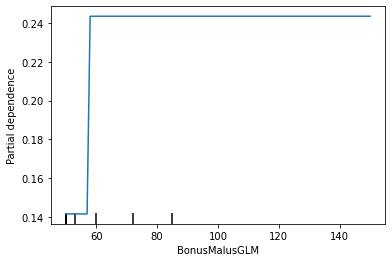

In [21]:
# Partial dependency plot
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(RF_freq, X_trn, ['BonusMalusGLM'])

### 2.6. Light GBM

📝 Complete the blank spaces and run the code

📝 Run the cell for the model results. What is the best model so far?

📢 Hints:
* https://lightgbm.readthedocs.io/en/v3.3.2/

In [25]:
import lightgbm as lgb

feat_cnt = ['Area', 'BonusMalusGLM', 'LogDensity'] # list with (3) continuous features
feat_cat  = ['VehPowerGLM', 'VehAgeGLM', 'DrivAgeGLM', 'VehBrandGLM', 'RegionGLM'] # list with (6) categorical features


# one hot encoding for categorical variables as DecisionTreeRegressor can only deal with numerical values
# https://www.educative.io/blog/one-hot-encoding
onehot_coded_trn_db = pd.get_dummies(trn_db[feat_cat])
onehot_coded_tst_db = pd.get_dummies(tst_db[feat_cat])

X_trn_lgbm = trn_db[feat_cnt + feat_cat]
X_tst_lgbm = tst_db[feat_cnt + feat_cat]

# Set response variable: frequency
y_trn = trn_db['Frequency']   # train dataset
y_tst = tst_db['Frequency']   # test dataset

for cat in feat_cat:
    X_trn_lgbm[cat] = X_trn_lgbm[cat].cat.codes
    X_tst_lgbm[cat] = X_tst_lgbm[cat].cat.codes

train_data = lgb.Dataset(X_trn_lgbm, label=y_trn, weight=expo_trn)

# Define gbm
param = {'objective': 'poisson'}
param['metric'] = 'poisson'
lgbm_freq = lgb.train(param, train_data)

# Get estimates
p_freq_trn      = lgbm_freq.predict(X_trn_lgbm) # train dataset
p_freq_tst_LGBM = lgbm_freq.predict(X_tst_lgbm) # test dataset

C:\Users\ik-ho\AppData\Local\Temp/ipykernel_10940/1214400208.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_trn_lgbm[cat] = X_trn_lgbm[cat].cat.codes
C:\Users\ik-ho\AppData\Local\Temp/ipykernel_10940/1214400208.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tst_lgbm[cat] = X_tst_lgbm[cat].cat.codes


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 610211, number of used features: 8
[LightGBM] [Info] Start training from score -1.774760


In [26]:
# Model results
mod_res = store_mod_res(mod_res, lgbm_freq, "lgbm_freq", y_freq_trn, p_freq_trn, expo_trn, y_freq_tst, p_freq_tst_LGBM, expo_tst, isGLM=False, isRF=False, isGBM=True)
mod_res

,model,in_sample_loss,out_sample_loss,aic,in_sample_gini,out_sample_gini,number_of_param
0,RF_freq,0.273098,0.270906,NaN,0.197028,0.203145,39.0
1,RF_freq,0.558230,0.557986,NaN,0.195617,0.201237,52.0
2,lgbm_freq,0.570834,0.574071,NaN,0.247442,0.245874,NaN


AttributeError: 'Booster' object has no attribute 'summary'

### 2.7. Final comparison

📝 Study the function `lift_chart`.
* What is this function doing? What are the expected outputs?

📝 Run `lift_chart` to obtain the lift chart for the models tested
* What can you conclude from these results? How do they relate with the observed in `mod_res`?


In [31]:
from sklearn.utils import gen_even_slices
def mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin

def lift_chart(estimates_preds, estimates_names, y_tst, expo_tst):
    """ Visual results from the mean_frequency_by_risk_group function.

    Parameters
    ----------
    estimates_preds: array-like with the models' predictions
    # Example: estimates_preds = [p_freq_tst_GLM, p_freq_tst_RT0, p_freq_tst_RF, p_freq_tst_LGBM]
    estimates_names: array-like with the models'names
    # Example: estimates_names = ['GLM', 'Decision Tree', 'Random Forest', 'Light GBM']
    expo_tst: array-like with the exposure
    y_tst: array-like with observed values

    Returns
    -------
    plot
    """

    n_rows_plot = int(np.ceil(len(estimates_names)/2))
    fig, ax = plt.subplots(nrows=n_rows_plot, ncols=2, figsize=(12, 8))
    plt.subplots_adjust(wspace=0.3)
    for axi, y_pred, model_name in zip(ax.ravel(), estimates_preds, estimates_names):
        y_true = y_tst.values
        exposure = expo_tst.values
        y_pred = y_pred
        q, y_true_seg, y_pred_seg = mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10
        )

        axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
        axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
        axi.set_xlim(0, 1.0)
        axi.set_ylim(0, 0.5)
        axi.set(
            title=model_name,
            xlabel="Fraction of samples sorted by y_pred",
            ylabel="Mean Frequency (y_pred)",
        )
        axi.legend()
    plt.tight_layout()

In [ ]:
lift_chart(['p_freq_tst_FL', 'p_freq_tst_GLM0', 'p_freq_tst_dt', 'p_freq_tst_RF', 'p_freq_tst_LGBM'], ['Flat Load', 'GLM', 'Decision Tree', 'Random Forest', 'Light GBM'], y_tst, expo_tst)

In [ ]:
mod_res

### 2.8. Challenge 🏆

Do you think it is possible to get **better models** than the 5 ones we went through?

Yes, it is quite possible since we only modelled using barely the default values. There is obviously room for improvement!
* One can try to tune any of the models trained so the depth, number of iterations/trees, number of features used, among others can be optimized
* One can improve the tuning using $k$-fold cross validation instead of modelling directly on the whole train dataset.


Do you want to challenge the models created and come with a better solution?

Then, take a look on the references hereunder and put your hands to work 💪
* https://lightgbm.readthedocs.io/en/v3.3.2/Parameters-Tuning.html
* https://optuna.org/
* https://github.com/microsoft/FLAML
* ChatGPT


To assess the model created you can use both functions  `store_mod_res` and `lift_chart`. Other metrics are also welcome.

📝 Pick one model and explore at least one improvement in the fitting of this model. Carefully explain your strategy!


## 3. Severity modeling

📝 You will now build some severity models as well, along the instructions outlined above:
- a naive GLM for claim severity; which distributional assmption do you propose?
- a GLM for claim severity, including features
- a tree / RF or GBM for claim severity.

Discuss your findings and observations.

## 🎉 End of Part II of the pricing case!